<a href="https://colab.research.google.com/github/mkrsteska/BSA2020_Team_Tissot_Project_2/blob/master/code/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

I tried using a different data set of fake&real news to see if a model trained on that could be used on the twitter database

**It does not work :(**

In [0]:
real_news = pd.read_csv("https://raw.githubusercontent.com/mkrsteska/BSA2020_Team_Tissot_Project_2/master/data/real_news.csv",
                        sep =';',
                        encoding='utf_8', 
                        dtype = 'unicode',
                        low_memory= False)

fake_news = pd.read_csv("https://raw.githubusercontent.com/mkrsteska/BSA2020_Team_Tissot_Project_2/master/data/fake_news.csv", 
                        sep =';',
                        encoding='utf_8', 
                        dtype = 'unicode',
                        low_memory= False)

In [0]:
df_train = pd.read_csv("https://raw.githubusercontent.com/DLaux/BSA2020_Team_Tissot_Project_2/master/data/train.csv", 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory=False)

df_test = pd.read_csv("https://raw.githubusercontent.com/DLaux/BSA2020_Team_Tissot_Project_2/master/data/test.csv", 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory=False)

In [0]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
df_train.groupby(["target"]).count()

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


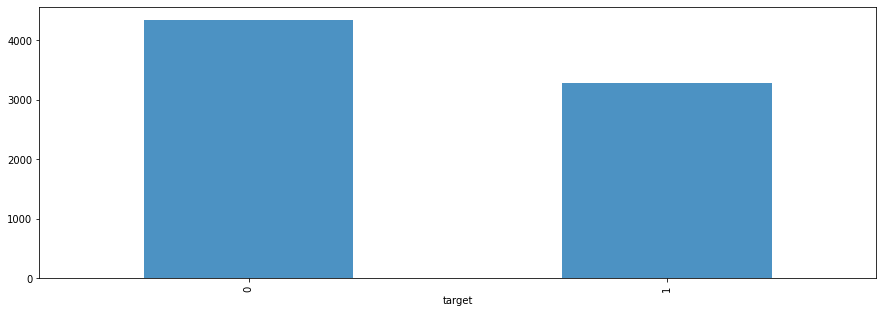

In [0]:
r1 = df_train[["id","target"]].groupby(["target"]).count()
r1.plot.bar(x=None, 
            y=None,
            figsize=(15,5), 
            alpha = 0.8, # make the plot 20% transparent
            legend = None, 
           )

## Preprocessing data

In [0]:
import nltk
nltk.download('stopwords')

import re

from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
X = df_train['text'].astype('str')
y = df_train["target"]

In [0]:
#encode the target 
lab_enc = preprocessing.LabelEncoder()
encoded_y = lab_enc.fit_transform(y)

In [0]:
# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.2, random_state=72, stratify=encoded_y)

### Text processing

In [0]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 30  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 28  # Maximum number of words in a sequence

In [0]:
'''Function to remove English stopwords from a Pandas Series.'''
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
'''Function to remove mentions, preceded by @, in a Pandas Series'''
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

def remove_URL(input_text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',input_text)

In [0]:
X_train = X_train.apply(lambda x: remove_URL(x)).apply(lambda x: remove_stopwords(x)).apply(lambda x: remove_mentions(x))

Tokenization

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=2, max_df=0.75, encoding='utf-8')
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(6090, 5499)

Bag of words

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(6090, 5499)

This is just to test how effectif these methods are for our data set, later on we will do every step in a pipeline

In [0]:
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer(min_df=3, max_df=0.75, encoding='utf-8')),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])

model = pipe.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.91      0.83       869
           1       0.84      0.63      0.72       654

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.80      0.79      0.78      1523

[[790  79]
 [243 411]]


## Selecting a model

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

classifiers = [   
    KNeighborsClassifier(n_neighbors = 10,weights = 'distance',algorithm = 'brute'),
    SVC(kernel="rbf", C=0.025, probability=True, random_state=42),
    NuSVC(probability=True, random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    MultinomialNB(),
    SGDClassifier(random_state=42),
    MLPClassifier(random_state=42)
    ]

for classifier in classifiers:
    pipe = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('smote', SMOTE()),
                     ('classifier', classifier)
                     ])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))
    
    predictions = pipe.predict(X_test)
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')
model score: 0.444
              precision    recall  f1-score   support

           0       0.73      0.04      0.08       869
           1       0.43      0.98      0.60       654

    accuracy                           0.44      1523
   macro avg       0.58      0.51      0.34      1523
weighted avg       0.60      0.44      0.30      1523

[[ 35 834]
 [ 13 641]]
SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
model score: 0.571


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.57      1.00      0.73       869
           1       0.00      0.00      0.00       654

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.41      1523

[[869   0]
 [654   0]]
NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=True, random_state=42, shrinking=True,
      tol=0.001, verbose=False)
model score: 0.786
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       869
           1       0.86      0.60      0.71       654

    accuracy                           0.79      1523
   macro avg       0.81      0.76      0.77      1523
weighted avg       0.80      0.79      0.78      1523

[[804  65]
 [261 393]]
DecisionTreeClassifier(cc

## Neural Network

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
text_MLP = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('smote', SMOTE()),
                     ('mlp', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 10), random_state=1, max_iter= 1000)),])
text_MLP = text_MLP.fit(X_train, y_train)



In [0]:
predictions = text_MLP.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       869
           1       0.73      0.70      0.72       654

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.76      1523
weighted avg       0.76      0.76      0.76      1523

[[700 169]
 [194 460]]


In [0]:


parameters = {
    #'vect__analyzer' : ('word', 'char'),
    #'vect__max_df': (0.75, 0.80, 0.85),
    #'vect__max_features': (None, 5000, 10000, 50000),
    
    'mlp__hidden_layer_sizes': [(100, 10),(100, 50),(200, 50),(50, 10)]
}


CV = GridSearchCV(text_MLP, parameters, n_jobs= 1)
                  
CV.fit(X_train, y_train)  
print(CV.best_params_) 
print(CV.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'mlp__hidden_layer_sizes': (100, 50)}
0.7663382594417077
